#1. Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. EDA

## Install and import necessary packages

In [ ]:
!pip install pyvi
!pip install emoji

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8.5/8.5 MB 28.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.1/1.1 MB 68.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 433.8/433.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import re
import emoji
from wordcloud import WordCloud
from pyvi.ViTokenizer import ViTokenizer
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
DATA_PATH = "/content/drive/MyDrive/midtermdata/"

os.listdir(DATA_PATH)

['cc.vi.300.vec',
 'dev.csv',
 'test.csv',
 'train.csv',
 'facebook_comment_2k7.csv',
 'facebook_comment_2k7.gsheet',
 'train.gsheet',
 'vietnamese-stopwords-dash.txt',
 'VnCoreNLP-1.1.1.jar',
 'Text_CNN_model_v1.h5',
 'GRU_model_v1.h5',
 'transformer_model']

## Load data 2k7

M·ª•c ƒë√≠ch x√¢y d·ª±ng model ph√°t hi·ªán 3 nh√£n ri√™ng bi·ªát: harrassment, hatespeech, normal n√™n c√°c nh√£n ch·ªâ c·∫ßn c√≥ ch·ª©a harrassment s·∫Ω l√† harrassment, c√≥ hatespeech s·∫Ω ƒë∆∞·ª£c xem l√† hatespeech, c√≤n l·∫°i l√† normal.

Trong vihsd: CLEAN (0), OFFENSIVE (1), and HATE (2)

Trong t·∫≠p 2k7 hi·ªán t·∫°i: harassment = HATE, hatespeech = OFFENSIVE, normal = CLEAN n√™n nh√£n cho t·∫≠p d·ªØ li·ªáu k·∫øt h·ª£p l√†:
'normal': 0, 'hate_speech': 1, 'harassment': 2

In [ ]:
# Load the dataset
FILE_PATH = "facebook_comment_2k7.csv"
df2k7 = pd.read_csv(DATA_PATH + FILE_PATH)
df2k7 = df2k7.drop(columns=['id', 'Unnamed: 0'], errors='ignore')
def adjust_label(label):
    if 'harassment' in label:
        return 2
    elif 'hate_speech' in label:
        return 1
    else:
        return 0

df2k7['label'] = df2k7['label'].apply(adjust_label)

In [ ]:
df2k7['label'].unique()

array([2, 0, 1])

In [ ]:
len(df2k7)

In [ ]:
# @title Label Frequency

df2k7['label'].value_counts().plot(kind='bar')

Do t√≠nh ph·ª©c t·∫°p v√† tinh vi c·ªßa l·ªùi n√≥i cƒÉm th√π v√† h√†nh vi qu·∫•y r·ªëi, t·∫≠p d·ªØ li·ªáu v·ªõi 2.700 nh·∫≠n x√©t c√≥ th·ªÉ kh√¥ng cung c·∫•p ƒë·ªß v√≠ d·ª• ƒë·ªÉ m√¥ h√¨nh h·ªçc m√°y t√¨m hi·ªÉu v√† kh√°i qu√°t h√≥a m·ªôt c√°ch hi·ªáu qu·∫£, ƒë·∫∑c bi·ªát n·∫øu nh·ªØng nh·∫≠n x√©t n√†y kh√¥ng ƒë∆∞·ª£c ph√¢n b·ªë ƒë·ªìng ƒë·ªÅu gi·ªØa c√°c class, nh∆∞ h√¨nh tr√™n d·ªØ li·ªáu kh√¥ng c√¢n b·∫±ng v√† c√≥ s·ªë l∆∞·ª£ng r·∫•t √≠t. ƒêi·ªÅu quan tr·ªçng l√† m√¥ h√¨nh ph·∫£i ti·∫øp x√∫c v·ªõi nhi·ªÅu ki·ªÉu ng√¥n ng·ªØ, s·∫Øc th√°i v√† ng·ªØ c·∫£nh kh√°c nhau ƒë·ªÉ ho·∫°t ƒë·ªông t·ªët tr√™n d·ªØ li·ªáu trong th·∫ø gi·ªõi th·ª±c v√† m·ªôt t·∫≠p d·ªØ li·ªáu h·∫°n ch·∫ø c√≥ th·ªÉ kh√¥ng n·∫Øm b·∫Øt ƒë∆∞·ª£c to√†n b·ªô c√°ch ng√¥n t·ª´ k√≠ch ƒë·ªông th√π ƒë·ªãch v√† h√†nh vi qu·∫•y r·ªëi c√≥ th·ªÉ bi·ªÉu hi·ªán trong ng√¥n ng·ªØ.

Do ƒë√≥, vi·ªác ƒë√†o t·∫°o m·ªôt m√¥ h√¨nh tr√™n t·∫≠p d·ªØ li·ªáu n√†y c√≥ th·ªÉ d·∫´n ƒë·∫øn m·ªôt h·ªá th·ªëng kh√¥ng ƒë·ªß m·∫°nh ƒë·ªÉ x·ª≠ l√Ω c√°c bi·ªÉu hi·ªán ƒëa d·∫°ng c·ªßa l·ªùi n√≥i cƒÉm th√π v√† qu·∫•y r·ªëi trong c√°c t√¨nh hu·ªëng kh√°c nhau, c√≥ kh·∫£ nƒÉng d·∫´n ƒë·∫øn t·ª∑ l·ªá d∆∞∆°ng t√≠nh gi·∫£ ho·∫∑c √¢m t√≠nh gi·∫£ cao khi ƒë∆∞·ª£c tri·ªÉn khai trong m√¥i tr∆∞·ªùng tr·ª±c ti·∫øp.

ƒê·ªÉ gi·∫£m thi·ªÉu ƒëi·ªÅu n√†y, h√£y xem x√©t c√°c k·ªπ thu·∫≠t nh∆∞ tƒÉng c∆∞·ªùng d·ªØ li·ªáu ƒë·ªÉ m·ªü r·ªông t·ªïng h·ª£p c√°c l·ªõp thi·ªÉu s·ªë, s·ª≠ d·ª•ng c√°c m√¥ h√¨nh ƒë∆∞·ª£c ƒë√†o t·∫°o tr∆∞·ªõc ho·∫∑c k·∫øt h·ª£p c√°c b·ªô d·ªØ li·ªáu b√™n ngo√†i. C√°ch ti·∫øp c·∫≠n n√†y c√≥ th·ªÉ mang l·∫°i cho m√¥ h√¨nh tr·∫£i nghi·ªám h·ªçc t·∫≠p phong ph√∫ h∆°n v√† c·∫£i thi·ªán hi·ªáu su·∫•t c·ªßa m√¥ h√¨nh trong vi·ªác ph√°t hi·ªán l·ªùi n√≥i cƒÉm th√π v√† h√†nh vi qu·∫•y r·ªëi.

## K·∫øt h·ª£p t·∫≠p d·ªØ li·ªáu ViHSD

Chia t·∫≠p 2k7 th√†nh train, val, test v·ªõi t·ªâ l·ªá 7:1:2

In [ ]:
# Split the data into train+val and test sets with stratification
train_val, test = train_test_split(df2k7, test_size=0.2, stratify=df2k7['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.125, stratify=train_val['label'], random_state=42)

In [ ]:
# Load the VIHSD dataset
vihsd_train_path = DATA_PATH + 'train.csv'
vihsd_dev_path = DATA_PATH + 'dev.csv'
vihsd_test_path = DATA_PATH + 'test.csv'

vihsd_train = pd.read_csv(vihsd_train_path)
vihsd_dev = pd.read_csv(vihsd_dev_path)
vihsd_test = pd.read_csv(vihsd_test_path)

In [ ]:
vihsd_train.head()

free_text  label_id
0  Em ƒë∆∞·ª£c l√†m fan c·ª©ng lu√¥n r·ªìi n√® ‚ù§Ô∏è reaction q...         0
1  ƒê√∫ng l√† b·ªçn m·∫Øt h√≠p l√≤ xo th·ª•t :))) b√™n vi·ªát n...         2
2           ƒê·∫≠u VƒÉn C∆∞·ªùng gi·ªù gi·ªëng th·∫±ng sida h∆°n √†         0
3  C√îN ƒê·ªí C·ª§C S√öC V√î NH√ÇN T√çNH ƒê·ªÄ NGHI VN. NH√Ä N∆Ø...         2
4  T·ª´ l√Ω thuy·∫øt ƒë·∫øn th·ª±c h√†nh l√† c·∫£ 1 c√¢u chuy·ªán ...         0

In [ ]:
combined_train = pd.concat([vihsd_train.rename(columns={'free_text': 'text'}), train.rename(columns={'label': 'label_id'})])
combined_dev = pd.concat([vihsd_dev.rename(columns={'free_text': 'text'}), val.rename(columns={'label': 'label_id'})])
combined_test = pd.concat([vihsd_test.rename(columns={'free_text': 'text'}), test.rename(columns={'label': 'label_id'})])

# Shuffle each combined dataset
combined_train = combined_train.sample(frac=1, random_state=42).reset_index(drop=True)
combined_dev = combined_dev.sample(frac=1, random_state=42).reset_index(drop=True)
combined_test = combined_test.sample(frac=1, random_state=42).reset_index(drop=True)

T·∫≠p train c·ªßa 2k7 tr∆∞·ªõc v√† sau khi b·ªï sung th√™m vihsd

In [ ]:
len(train), len(vihsd_train), len(combined_train)

(1890, 24048, 25938)

In [ ]:
combined_train.head()

X√≥a c√°c row b·ªã NaN

In [ ]:
combined_train.info()

In [ ]:
combined_train.dropna(inplace=True)

## The distributions of three labels on the train, val, and test sets

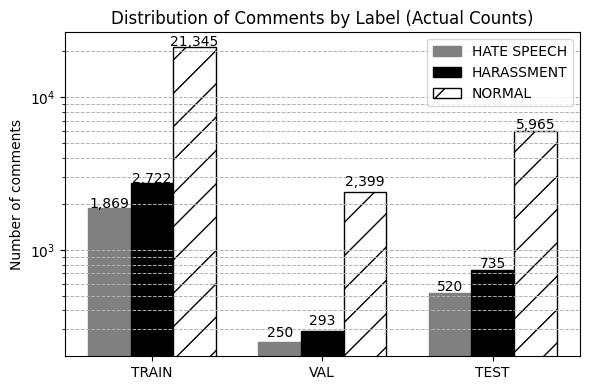

In [ ]:
label_id_to_name = {0: 'NORMAL', 1: 'HATE', 2: 'HARASSMENT'}

train_label_counts = combined_train['label_id'].map(label_id_to_name).value_counts()
val_label_counts = combined_dev['label_id'].map(label_id_to_name).value_counts()
test_label_counts = combined_test['label_id'].map(label_id_to_name).value_counts()

fig, ax = plt.subplots(figsize=(6, 4))

# Heights of the bars
hate_speech_counts = [train_label_counts.get('HATE', 0), val_label_counts.get('HATE', 0), test_label_counts.get('HATE', 0)]
harassment_counts = [train_label_counts.get('HARASSMENT', 0), val_label_counts.get('HARASSMENT', 0), test_label_counts.get('HARASSMENT', 0)]
normal_counts = [train_label_counts.get('NORMAL', 0), val_label_counts.get('NORMAL', 0), test_label_counts.get('NORMAL', 0)]

# The x position of bars
barWidth = 0.25
r1 = np.arange(len(hate_speech_counts))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Plotting the bars
plt.bar(r1, hate_speech_counts, color='grey', width=barWidth, edgecolor='grey', label='HATE SPEECH')
plt.bar(r2, harassment_counts, color='black', width=barWidth, edgecolor='black', label='HARASSMENT')
plt.bar(r3, normal_counts, color='white', width=barWidth, edgecolor='black', hatch='/', label='NORMAL')

# Adding the annotations for counts on top of the bars
def add_labels(x, counts):
    for i in range(len(x)):
        plt.text(x[i], counts[i] + max(counts) * 0.01, f'{counts[i]:,.0f}', ha='center')
add_labels(r1, hate_speech_counts)
add_labels(r2, harassment_counts)
add_labels(r3, normal_counts)

# General layout
plt.xticks([r + barWidth for r in range(len(hate_speech_counts))], ['TRAIN', 'VAL', 'TEST'])
plt.ylabel('Number of comments')
plt.yscale('log')
plt.title('Distribution of Comments by Label (Actual Counts)')
plt.legend()

plt.grid(which='both', axis='y', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

Bi·ªÉu ƒë·ªì cho th·∫•y s·ª± m·∫•t c√¢n b·∫±ng ƒë√°ng k·ªÉ trong t·∫≠p d·ªØ li·ªáu, v·ªõi s·ªë l∆∞·ª£ng nh·∫≠n x√©t 'normal' v∆∞·ª£t xa s·ªë l∆∞·ª£ng nh·∫≠n x√©t v·ªÅ 'hate_speech' v√† 'harassment'.

1. **M·∫•t c√¢n b·∫±ng**: C√°c m√¥ h√¨nh c√≥ xu h∆∞·ªõng thi√™n v·ªÅ class ƒëa s·ªë, c√≥ kh·∫£ nƒÉng d·∫´n ƒë·∫øn vi·ªác x√°c ƒë·ªãnh k√©m c√°c class thi·ªÉu s·ªë.
2. **Overfitting**: D·ªØ li·ªáu h·∫°n ch·∫ø v·ªÅ 'hate_speech' v√† 'harassment' c√≥ th·ªÉ khi·∫øn m√¥ h√¨nh overfitting d·ªØ li·ªáu ƒë√†o t·∫°o, c·∫£n tr·ªü kh·∫£ nƒÉng kh√°i qu√°t h√≥a c·ªßa m√¥ h√¨nh.
3. C√≥ th·ªÉ kh√¥ng c√≥ ƒë·ªß s·ª± ƒëa d·∫°ng trong c√°c v√≠ d·ª• v·ªÅ hate_speech v√† harassment ƒë·ªÉ n·∫Øm b·∫Øt ƒë∆∞·ª£c c√°c s·∫Øc th√°i c·ªßa n·ªôi dung ƒë√≥.
4. **Metric**: Accuracy kh√¥ng ph·∫£i l√† s·ªë li·ªáu ƒë√°ng tin c·∫≠y do t√≠nh m·∫•t c√¢n b·∫±ng n√™n s·∫Ω d√πng ƒëi·ªÉm F1 mang l·∫°i nhi·ªÅu th√¥ng tin h∆°n.

In [ ]:
# Vietnamese stopwords list
STOPWORDS = 'vietnamese-stopwords-dash.txt'
with open(DATA_PATH + STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [ ]:

# Function to generate word clouds
def generate_word_cloud(text_series, title):
    text = ' '.join(text_series)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds for each class
for label in combined_train['label_id'].unique():
    generate_word_cloud(combined_train[combined_train['label_id'] == label]['text'].astype(str), f'Word Cloud for {label_id_to_name[label]} Comments')


NameError: name 'label_id_to_name' is not defined

In [ ]:
combined_train[(combined_train['label_id'] == 1) & (combined_train['text'].str.contains(' m '))].head()

text  label_id
598   Thanh Tuy·ªÅn c√¢m m·∫π m·ªìm ƒëi,t·ªët ƒëb,t b·ªã ch√∫ng m ...         1
693   Tr·ªùi m√° l·∫°i ƒë·∫πp Lan T∆∞·ªùng m bi·∫øt anh n√†y kh√¥ng...         1
750   DƒÉm ba con ch√≥ t√≠n d·ª•ng ƒëen t·ª•i m d√°m t·ªõi nh√† ...         1
1276                                     B·ªë m ƒë√©o s·ª£ ok         1
1648  :))))) nay thi doc quyen :V d' cho tu nhan tha...         1

In [ ]:
vihsd_train[(vihsd_train['label_id'] == 1) & (vihsd_train['free_text'].str.contains(' m '))].head(20)

free_text  label_id
2115   N√≥ th√≠ch m√¨nh n√≥ ƒë√£ y√™u cmm lu√¥n ch·ª© b·∫Øt m ƒë·ª£i...         1
4406                         Ph·∫†m m·∫°ng m lag ch·ª© ch·∫≠m cc         1
8601                          ƒê√¥ng Ca l√† ƒë·ªãt c·ª• m ng·ªß ƒëi         1
13409     cc, t b·∫Øn 3 ph√°t r·ªìi ƒë·∫•y, ngon vcl ? m ƒëui √† ?         1
14061                                     B·ªë m ƒë√©o s·ª£ ok         1
14087                   Vitamin Nhung cƒë m ch·ª© ai n·ªØa üòÅüòÅ         1
14931       C≈©g ch∆∞a bi·∫øt tin ai ƒëc m ∆°i =)) ƒë·ªìn nh∆∞ l·ªùi         1
15122  C≈©ng ƒë·ªìng √Ω vs ad nh∆∞ng b·∫°n m t·ª´ khi tham gia ...         1
15353                  T·ª•t m·∫π m ra cho nhanh ƒë·ª° ph·∫£i m·∫∑c         1
15667                   ƒêinhh Th·ªã Ho√†ii Thuu ng·ªß m·∫π m ƒëi         1
17147  ƒë√©o ph·∫£i c√°i g√¨ th√≠ch th·ª≠ l√† th·ª≠ ƒëc nh√°,nh·∫•t l...         1
17263  :))))) nay thi doc quyen :V d' cho tu nhan tha...         1
17709  Dm tao c√≤n nh·ªõ l·∫ßn t ƒëi thi h·ªçc sinh gi·ªèi l·ªõp ...         1
18019                      Ghi th√™m ch·ªØ ƒë*t ch·ªã m nx :))         1
18300  ·ªù ·ªù . n·ª£ th√¨ ch√∫ng m n·ª£ nh√©. :T t ƒë√©o c√≥ n·ª£ ai...         1
20055  Ng·ªçc H·∫£i √™, bi·ªÉu t∆∞·ª£ng cl c·ªßa m th√†nh trend b√™...         1

# Modeling

## Preprocessing





1.   Word-segmentating texts into words by the pyvi tool
2.    Removing stopwords
3. Changing all texts into lower cases
4. Removing special characters such as hashtags, urls, and mention tags.






In [ ]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences

def remove_special_characters(text):
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    return text

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = remove_special_characters(text)
    text = emoji.replace_emoji(text,"")
    text = text.lower() if lowercased else text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X_processed = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    non_empty_indices = [idx for idx, ele in enumerate(X_processed) if ele]
    X_processed = pd.Series(X_processed)[non_empty_indices].tolist()
    y_processed = y.iloc[non_empty_indices].tolist()
    return X_processed, y_processed


In [ ]:
train_X, train_y = pre_process_features(combined_train['text'], combined_train['label_id'], tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(combined_dev['text'], combined_dev['label_id'], tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(combined_test['text'], combined_test['label_id'], tokenized=True, lowercased = True)

T·∫≠p train tr∆∞·ªõc v√† sau khi pre_process

In [ ]:
train_X[:10]

['Mn review g√¨ ƒë√≥ nh∆∞ ki·ªÉu phim hay qtqd , c√°c ki·ªÉu ƒëi ƒë·ªÉ m√¨nh c√≤n hi_v·ªçng ü§î',
 'Cho miÃÄnh xin ƒëc nheÃÅ',
 'S·ªëng ch·∫≠m th√¥i c√°c m√° = ) )',
 'Ai cho em c√°i link c·ªßa b·ªô_t·ªôc mixi gaming v·ªõi em t√¨m kh√¥ng th·∫•y : ( (',
 'Haizzz_Nhung th√¨ ƒë√°ng tr√°ch th·∫≠t nh∆∞ng t√¨nh_h√¨nh nh∆∞ n√†y th√¨ Vi·ªát_Nam v·∫´n c√≥_th·ªÉ ti·∫øp_nh·∫≠n th√™m b·ªánh_nh√¢n t·ª´ n∆∞·ªõc_ngo√†i v·ªÅ ( (',
 'Ma ba rat la xinh xan con noi thiet',
 'H√†i ...!!',
 'Th·∫±ng ad " ph·∫£n_ƒë·ªông " ch·ªâ gi·ªèi " xuy√™n_t·∫°c ƒë∆∞·ªùng n·ªëi ch√≠nh_s√°ch c·ªßa ƒë√£ng v√† nh√† l∆∞·ªõc , b√¥i_nh·ªç c√°c anh_h√πng n·ª±c n∆∞·ª£ng v≈©_trang nh√¢n_d√¢n " .H·∫øt ƒë·∫∑t m√¨n xe_ƒë√≤ th√¨ ƒë·∫∑t m√¨n b∆∞u_ƒëi·ªán , n√©m l·ª±u_ƒë·∫°n v√†o ch·ª£ v√†o r·∫°p_h√°t , ph√°o_k√≠ch v√†o nh√† d√¢n v√†o tr∆∞·ªùng_h·ªçc ko ph·∫£i l√† kh·ªßng_b·ªë kh·ªßng m·∫π g√¨ h·∫øt , ph·∫£i g·ªçi l√† " ƒëi n√†m k√°ch m·ªánh " m·ªõi ƒë√∫ng .',
 'H√≥ng qu√° ƒëa : v',
 'Ph·ª•c_v·ª• gi·∫£i_tr√≠ cho c·∫£ ƒë·∫°i_ƒë·ªôi m√

In [ ]:
pd.set_option('max_colwidth',800)

In [ ]:
combined_train.head(10)

text  \
0                                                                                                                                                                                                                                                           Mn review g√¨ ƒë√≥ nh∆∞ ki·ªÉu phim hay qtqd, c√°c ki·ªÉu ƒëi ƒë·ªÉ m√¨nh c√≤n hi v·ªçng ü§î   
1                                                                                                                                                                                                                                                                                                               Cho miÃÄnh xin ƒëc nheÃÅ   
2                                                                                                                                                                                                                                                                                                           S·ªëng ch·∫≠m th√¥i c√°c m√° =))   
3                                                                                                                                                                                                                                                                 Ai cho em c√°i link c·ªßa b·ªô t·ªôc mixi gaming v·ªõi em t√¨m kh√¥ng th·∫•y :((   
4                                                                                                                                                                                                       Haizzz Nhung th√¨ ƒë√°ng tr√°ch th·∫≠t nh∆∞ng t√¨nh h√¨nh nh∆∞ n√†y th√¨ Vi·ªát Nam v·∫´n c√≥ th·ªÉ ti·∫øp nh·∫≠n th√™m b·ªánh nh√¢n t·ª´ n∆∞·ªõc ngo√†i v·ªÅ ((   
5                                                                                                                                                                                                                                                                                                 Ma ba rat la xinh xan con noi thiet   
6                                                                                                                                                                                                                                                                                                                           H√†i ...!!   
7  Th·∫±ng ad "ph·∫£n ƒë·ªông" ch·ªâ gi·ªèi "xuy√™n t·∫°c ƒë∆∞·ªùng n·ªëi ch√≠nh s√°ch c·ªßa ƒë√£ng v√† nh√† l∆∞·ªõc, b√¥i nh·ªç c√°c anh h√πng n·ª±c n∆∞·ª£ng v≈© trang nh√¢n d√¢n". H·∫øt ƒë·∫∑t m√¨n xe ƒë√≤ th√¨ ƒë·∫∑t m√¨n b∆∞u ƒëi·ªán, n√©m l·ª±u ƒë·∫°n v√†o ch·ª£ v√†o r·∫°p h√°t, ph√°o k√≠ch v√†o nh√† d√¢n v√†o tr∆∞·ªùng h·ªçc ko ph·∫£i l√† kh·ªßng b·ªë kh·ªßng m·∫π g√¨ h·∫øt, ph·∫£i g·ªçi l√† "ƒëi n√†m k√°ch m·ªánh" m·ªõi ƒë√∫ng.   
8                                                                                                                                                                                                                                                                                                                      H√≥ng qu√° ƒëa :v   
9                                                                                                                                                                                                          Ph·ª•c v·ª• gi·∫£i tr√≠ cho c·∫£ ƒë·∫°i ƒë·ªôi m√∫a c·ªôt gi·ªèi ch·ªãu ƒë√≤n t·ªët chuy√™n m·ªü mini show m·ª´ng ƒë·∫£ng m·ª´ng xu√¢n m·ª´ng ƒë·∫•t n∆∞·ªõc ƒë·ªïi m·ªõi:))   

   label_id  
0         0  
1         0  
2         0  
3         0  
4         0  
5         0  
6         0  
7         2  
8         0  
9         0

Fasttext Embedding

In [ ]:
EMBEDDING_FILE = 'cc.vi.300.vec'
embeddings_index = {}
with open(DATA_PATH + EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
vocabulary_size = 10000
embedding_dim = 300

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
sequence_length = 100

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)
    return X, y

# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [ ]:
train_X[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  301, 1754,   87,  139, 9857,   87,    1,
        1239],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [ ]:
train_y[:2]

array([[1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Text-CNN

In [ ]:
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 300)             6449700   ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 100, 300, 1)          0         ['embedding[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 99, 1, 32)            19232     ['reshape[0][0]']             
                                                                                              

In [ ]:
MODEL_FILE = 'Text_CNN_model_v1.h5'
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(DATA_PATH + MODEL_FILE)

Epoch 1/40
101/101 [==============================] - 40s 277ms/step - loss: 0.8129 - accuracy: 0.7685 - val_loss: 0.6768 - val_accuracy: 0.8151
Epoch 2/40
101/101 [==============================] - 10s 103ms/step - loss: 0.6158 - accuracy: 0.8236 - val_loss: 0.5659 - val_accuracy: 0.8157
Epoch 3/40
101/101 [==============================] - 9s 86ms/step - loss: 0.5278 - accuracy: 0.8284 - val_loss: 0.5077 - val_accuracy: 0.8191
Epoch 4/40
101/101 [==============================] - 6s 53ms/step - loss: 0.4803 - accuracy: 0.8360 - val_loss: 0.4785 - val_accuracy: 0.8294
Epoch 5/40
101/101 [==============================] - 4s 44ms/step - loss: 0.4468 - accuracy: 0.8441 - val_loss: 0.4568 - val_accuracy: 0.8362
Epoch 6/40
101/101 [==============================] - 4s 41ms/step - loss: 0.4191 - accuracy: 0.8505 - val_loss: 0.4384 - val_accuracy: 0.8420
Epoch 7/40
101/101 [==============================] - 4s 36ms/step - loss: 0.3967 - accuracy: 0.8575 - val_loss: 0.4252 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
cf1

array([[5684,   92,  154],
       [ 245,  162,  113],
       [ 340,   51,  344]])

In [ ]:
y_pred[:50]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0])

In [ ]:
f1_scores_per_class = f1_score(test_y, y_pred, average=None)

# In F1 score cho m·ªói class
for i, score in enumerate(f1_scores_per_class):
    print(f"F1 Score for class {i}: {score}")

F1 Score for class 0: 0.9318796622673989
F1 Score for class 1: 0.39272727272727276
F1 Score for class 2: 0.5111441307578009


In [ ]:
evaluation = f1_score(test_y, y_pred, average='micro')
evaluation

0.8609603340292276

In [ ]:
f1_score(test_y, y_pred, average='macro')

0.613786100567483

In [ ]:
accuracy_score(test_y, y_pred)

0.8609603340292276

<Axes: >

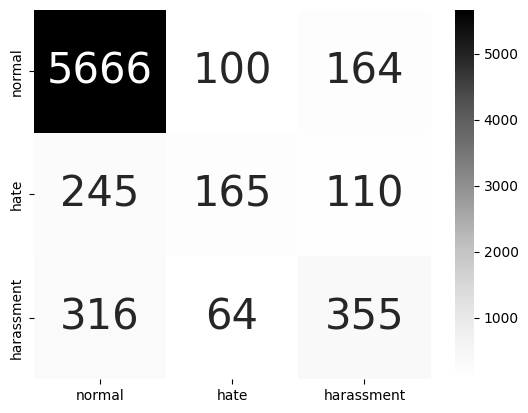

In [ ]:
df_cm1 = pd.DataFrame(cf1, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
test_X_2k7, test_y_2k7 = pre_process_features(test['text'], test['label'], tokenized=True, lowercased = True)
test_X_2k7, test_y_2k7 = make_featues(test_X_2k7, test_y_2k7, tokenizer, is_one_hot_label=False)

In [ ]:
prediction_2k7 = model.predict(test_X_2k7, batch_size=batch_size, verbose=0)
y_pred_2k7 = prediction_2k7.argmax(axis=-1)

cf2k7 = confusion_matrix(test_y_2k7, y_pred_2k7)

In [ ]:
accuracy_score(test_y_2k7, y_pred_2k7)

0.8277777777777777

In [ ]:
f1_score(test_y_2k7, y_pred_2k7, average='macro')

0.6058923714380131

<Axes: >

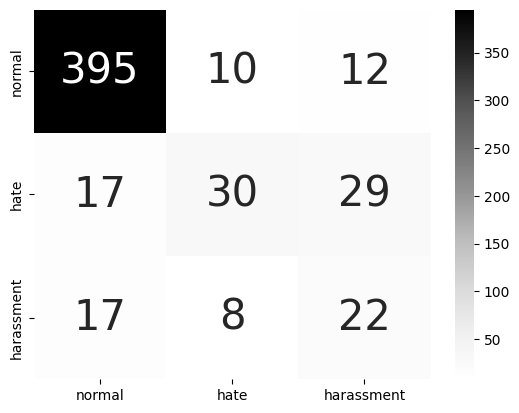

In [ ]:
df_cm2k7 = pd.DataFrame(cf2k7, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm2k7, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## GRU

In [ ]:
from keras.layers import Dense, Input, Bidirectional, GRU
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(3, activation="softmax")(conc)

# this creates a model that includes
model = Model(inputs=input, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 300)             6449700   ['input_2[0][0]']             
                                                                                                  
 spatial_dropout1d (Spatial  (None, 100, 300)             0         ['embedding_1[0][0]']         
 Dropout1D)                                                                                       
                                                                                                  
 bidirectional (Bidirection  (None, 100, 160)             183360    ['spatial_dropout1d[0][0

In [ ]:
batch_size = 256
epochs = 40

MODEL_FILE = 'GRU_model_v1.h5'
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(dev_X, dev_y))
model.save(DATA_PATH + MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf2 = confusion_matrix(test_y, y_pred)

Epoch 1/40
101/101 [==============================] - 19s 135ms/step - loss: 0.8235 - accuracy: 0.8147 - val_loss: 0.6309 - val_accuracy: 0.8151
Epoch 2/40
101/101 [==============================] - 7s 66ms/step - loss: 0.5864 - accuracy: 0.8224 - val_loss: 0.5851 - val_accuracy: 0.8151
Epoch 3/40
101/101 [==============================] - 7s 67ms/step - loss: 0.5453 - accuracy: 0.8225 - val_loss: 0.5472 - val_accuracy: 0.8151
Epoch 4/40
101/101 [==============================] - 5s 44ms/step - loss: 0.4965 - accuracy: 0.8269 - val_loss: 0.4909 - val_accuracy: 0.8283
Epoch 5/40
101/101 [==============================] - 5s 46ms/step - loss: 0.4357 - accuracy: 0.8472 - val_loss: 0.4456 - val_accuracy: 0.8413
Epoch 6/40
101/101 [==============================] - 4s 36ms/step - loss: 0.3915 - accuracy: 0.8597 - val_loss: 0.4245 - val_accuracy: 0.8443
Epoch 7/40
101/101 [==============================] - 4s 36ms/step - loss: 0.3626 - accuracy: 0.8685 - val_loss: 0.4140 - val_accuracy: 0.84

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
f1_scores_per_class = f1_score(test_y, y_pred, average=None)

# In F1 score cho m·ªói class
for i, score in enumerate(f1_scores_per_class):
    print(f"F1 Score for class {i}: {score}")

F1 Score for class 0: 0.9239903001923239
F1 Score for class 1: 0.3820459290187892
F1 Score for class 2: 0.48726772195457674


In [ ]:
accuracy_score(test_y, y_pred)

0.843562978427279

In [ ]:
f1_score(test_y, y_pred, average='micro')

0.843562978427279

In [ ]:
f1_score(test_y, y_pred, average='macro')

0.6013800148529169

<Axes: >

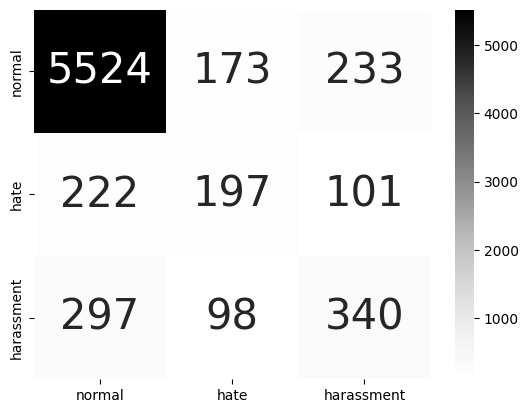

In [ ]:
df_cm2 = pd.DataFrame(cf2, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

Danh gia tren tap 2k7

In [ ]:
prediction_2k7 = model.predict(test_X_2k7, batch_size=batch_size, verbose=0)
y_pred_2k7 = prediction_2k7.argmax(axis=-1)

cf2k7 = confusion_matrix(test_y_2k7, y_pred_2k7)

In [ ]:
accuracy_score(test_y_2k7, y_pred_2k7)

0.812962962962963

In [ ]:
f1_score(test_y_2k7, y_pred_2k7, average='macro')

0.590143571417376

<Axes: >

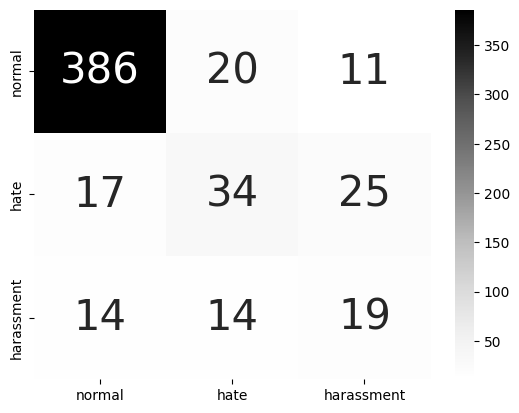

In [ ]:
df_cm2k7 = pd.DataFrame(cf2k7, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm2k7, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## PhoBERT

In [ ]:
!pip install vncorenlp

In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2024-04-05 09:45:24--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‚ÄòVnCoreNLP-1.1.1.jar‚Äô

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  91.2MB/s    in 0.3s    

2024-04-05 09:45:25 (91.2 MB/s) - ‚ÄòVnCoreNLP-1.1.1.jar‚Äô saved [27412575/27412575]

--2024-04-05 09:45:25--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiti

In [ ]:
from vncorenlp import VnCoreNLP

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
def preprocess(text, tokenized = True, lowercased = True):
    # text = filter_stop_words(text, stopwords)
    # text = remove_special_characters(text)
    # text = emoji.replace_emoji(text,"")
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X_processed = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    non_empty_indices = [idx for idx, ele in enumerate(X_processed) if ele]
    X_processed = pd.Series(X_processed)[non_empty_indices].tolist()
    y_processed = y.iloc[non_empty_indices].tolist()
    return X_processed, y_processed

In [ ]:
train_X, train_y = pre_process_features(combined_train['text'], combined_train['label_id'], tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(combined_dev['text'], combined_dev['label_id'], tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(combined_test['text'], combined_test['label_id'], tokenized=True, lowercased = False)

In [ ]:
test_X_2k7, test_y_2k7 = pre_process_features(test['text'], test['label'], tokenized=True, lowercased = False)

In [ ]:
pip install transformers[torch] accelerate -U

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8.8/8.8 MB 15.6 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 290.1/290.1 kB 6.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23.7/23.7 MB 24.9 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 823.6/823.6 kB 10.9 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14.1/14.1 MB 34.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)
test_2k7_encodings = tokenizer(test_X_2k7, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)
test_2k7 = BuildDataset(test_2k7_encodings, test_y_2k7)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir=DATA_PATH + "transformer_model/phobert-v3/",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

trainer.train()
trainer.save_model(DATA_PATH + "/transformer_model/phobert-v3/")

# y_pred_classify = trainer.predict(test_dataset)

# y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
# y_true = test_y

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(DATA_PATH + "/transformer_model/phobert-v3/")

In [ ]:
training_args = TrainingArguments(
    output_dir=DATA_PATH + "transformer_model/phobert-v3/",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

# Predict on the test dataset
y_pred_classify = trainer.predict(test_dataset)

# Extract predictions
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
cf1 = confusion_matrix(y_true, y_pred)

In [ ]:
f1_scores_per_class = f1_score(y_true, y_pred, average=None)

# In F1 score cho m·ªói class
for i, score in enumerate(f1_scores_per_class):
    print(f"F1 Score for class {i}: {score}")

F1 Score for class 0: 0.9408668476025989
F1 Score for class 1: 0.43394199785177234
F1 Score for class 2: 0.5792592592592593


In [ ]:
accuracy_score(y_true,y_pred)

0.874376731301939

In [ ]:
f1_score(y_true, y_pred, average='micro')

0.874376731301939

In [ ]:
f1_score(y_true, y_pred, average='macro')

0.6513560349045435

<Axes: >

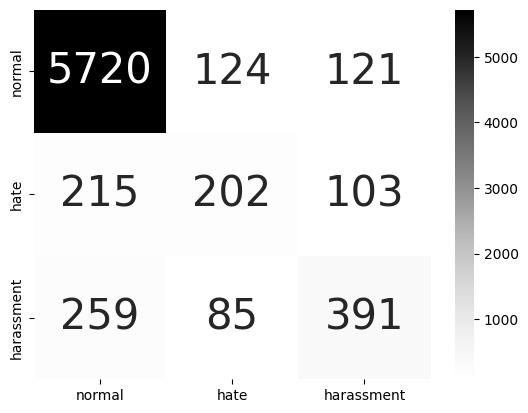

In [ ]:
df_cm1 = pd.DataFrame(cf1, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
prediction_2k7 = trainer.predict(test_2k7)
y_pred_2k7 = np.argmax(prediction_2k7.predictions, axis=-1)

cf2k7 = confusion_matrix(test_y_2k7, y_pred_2k7)

In [ ]:
accuracy_score(test_y_2k7, y_pred_2k7)

0.8648148148148148

In [ ]:
f1_score(test_y_2k7, y_pred_2k7, average='macro')

0.6791154424281035

<Axes: >

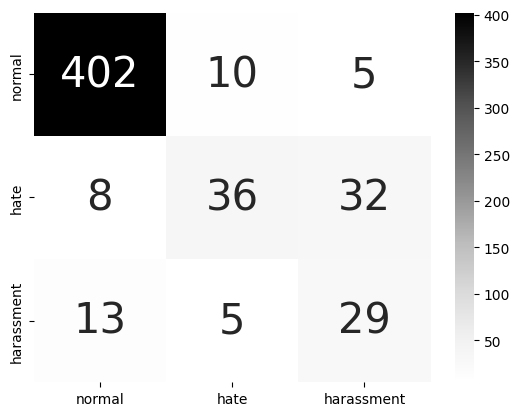

In [ ]:
df_cm2k7 = pd.DataFrame(cf2k7, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm2k7, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
misclassified_indices = np.where((np.array(y_true) != 0) & (y_pred == 0))[0]

In [ ]:
len(misclassified_indices)

474

In [ ]:
combined_test.iloc[misclassified_indices].head(20)

text  label_id
0    t·ª´ d·ªãch n√†y th·∫•y √Ω th·ª©c ng∆∞·ªùi nh·∫≠t xƒÉng ƒë·ªï n·ª≠a...         2
14                 K c√≥ ngh√¨n n√†o gi√∫p d√¢n th√¨ n√≠n ƒëi!         2
16    Yenie Cao ri·∫øt m·∫∑p nh∆∞ heo r m√† cho ƒÉn qu√†i üò≠üò≠üò≠üò≠         2
18                Nguy·ªÖn ƒê·ª©c √Ånh kh√¥n h∆°n c·∫£ h·ªç nh√† m.         2
21                        T√¢y n√≥ l·∫°i b·∫£o m·ªõi tr·ªën vi·ªán         1
25                            Tr√πm cu·ªëi cmn h√∫ v√≠a :))         1
82   S√∫c v·∫≠t t·ª´ nhan s·∫Øc ƒë·∫øn nh√¢n c√°ch s√∫c ph·∫°m lo√†...         2
111                                  Xem b·ª±c m√¨nh th√™m         1
121  Cu·ªën dell nh·∫∑t ƒëc m·ªìm, to√†n danh h√†i ƒë·∫•t Vi·ªát :))         1
138          Ch·ªó n√†y ƒëit ph·∫£i ch·ªó g·∫° ƒë·ªãt nh√© hahhahah.         1
166  Ph·∫£i,VN v√¥ s·ªë tham nh≈©ng,l·∫°i v·ª• n·ªØa ƒë√¢y,s·∫Øp ƒë·∫°...         1
192  B·∫•t h·∫°nh nh·∫•t cu·ªôc ƒë·ªùi l√† ra tr∆∞·ªùng r·ªìi m√† b·∫°n...         1
208  biÃ£ t√¢m th√¢ÃÄn v√¢ÃÉn coÃÅ th√™Ãâ coÃÅ hoÃ£c viÃ£ TS nh...         2
214  A ƒë·ª´ng c√≥ gi·ªëng ch·ªã T·ªãp ƒë·∫•y nh√©, th√¥ng b√°o c√°c...         2
263                                           lo·∫°n c·ª±c         1
269                                   th·∫ßy ch∆°i b·∫©n vl         2
284                            B√∫ l ng·ªçc Trinh s·∫Ω tinh         2
290  Mua s·∫Øt v·ª•n v·ªÅ l√†m ph∆∞∆°ng ti·ªán chi·∫øn ƒë·∫•u! ƒê·∫Øng...         1
299  Tao g√µ ch·ªõt m·∫π m√†y ch·ª© ·ªü ƒë√≥ m√† m√∫a . Abe said :))         2
302  c√≥ ti·ªÅn c·ª© l√†m,ch·ªâ c√≥ b·ªçn kh√¥ng c√≥ ti·ªÅn l√†m m·ªõ...         2

In [ ]:
misclassified_indices = np.where((np.array(test_y_2k7) ==1) & (y_pred_2k7 == 2))[0]

In [ ]:
len(misclassified_indices)

32

In [ ]:
pd.set_option('max_colwidth', 800)

In [ ]:
test.iloc[misclassified_indices]

text  label
1162                                                                                                                                                                                                         Ph·∫°m Th√°i Ho√†ng Long ·ªì lo·∫°i m ƒë c√£i dc l√† l·∫°i ƒë·ªãt m·∫π m√†y √†, lo·∫°n lu√¢n vcl       1
161                                                                                                                                                                                                                                          Joseph Tu·∫•n Anh T m√† ƒÉn hi·∫øp m √† th·∫±ng l·ªìn      1
1507                                                                                                                                                                                                            Anh Duy l·∫°i ch√≥ n·ªØaüê∂\nC√°i dm ch√≥ c·∫Øn ch√≥ ƒÉn c·ª©t ƒëi ƒë·ª´ng c√≥ ƒëi c·∫Øn ng∆∞·ªùi      1
1920                                                                                                                                                                                                                       Khanh Pham Van m√†y ƒëi h·ªèi n√≥ ƒëi! ƒêm ngu l·ªìn t·ªè v·∫ª hi·ªÉu bi·∫øt.      1
1395                                                                                                                                                                                                                         M√° s·ª≠ cho ƒë·∫πp con ƒëƒ© ƒë√≥ nha m√° nghe n√≥ ns m√† t·ª©c thi·ªát ch·ª©      1
1211                                                                                                                                                                                                                               Hi·ªÅn H√©n th√¥ng c·∫£m cho con m·ª• ƒëi√™n ƒë·∫•y t√Ω ƒëi ch·ªã √™ii      1
2106                                                                                                                Tui xin h·ªèi t·ª•i con g√°i th·ª≠ m√†y b·ªã ƒë√°nh trc m·∫∑t bi·∫øt bao ng∆∞·ªùi v c√≥ bi·∫øt nh·ª•c ko may cho m√†y l√† ki·∫øm ƒëc th·∫±ng ck bt nh·ªãn m√†y g·∫∑p m√°y ƒë·ª©a kh√°c ƒë√°nh cho m√†y tung l√¥l      1
2229                                                                                                                                    Dcm may thang lon chung may ngu vay. Bon cho cong an ko ƒë√°nh nhung no goi ngu√≤i khac toi ƒë√°nh. Ch√∫ng may song ma √©o biet gi chet het ƒëi bon ngu      1
2161  H√πng S∆°n th·∫±ng ƒë√©o boÃÄ ch·ªØa hoang naÃÄy.maÃÄy bi√™ÃÅt tao vuÃÄng naÃÄo kh√¥ng maÃÄ vaÃÄo suÃâa  v·∫≠y? DoÃÄng hoÃ£ tao ƒëi√™ÃÄu coÃÅ 1 s·ªë ng∆∞∆°ÃÄi laÃÄm vi√™Ã£c vaÃÄ theo 2 ch·∫ø ƒë·ªô.t√¥n giaÃÅo cuÃÉng coÃÅ thi√™n chuÃÅa nghen th·∫±ng ƒë·∫ßu boÃÄ.nh∆∞ng khi hoÃÄa biÃÄnh 2 phiÃÅa v·∫´n nhiÃÄn nhau vaÃÄ giuÃÅp ƒë·ª° l·∫´n nhau      1
567                                           H·ªìng Th∆°m  h·∫øt chia s·∫ª r·ªìi l·∫°i b√¨nh lu·∫≠n x√†m l·ªìn ƒë·ªÉ lzi ƒë·ªÉ ch√∫ng n√≥ th·∫•y r·ªìi c∆∞·ªùi v√†o m·∫∑t cho √† b·ªõt b·ªõt ƒëi ƒë·ªãt m·∫π k c√≥ ti·ªÅn ms bu·ªìn ƒëi bu·ªìn v√¨ 3 c√°i th·∫±ng v√°c bu·ªìi ƒëi kh·∫Øp th·∫ø gian lm l·ªìn g√¨ ns m√£i v·∫´n th·∫ø ƒëm ngu n√≥ √≠t th√¥i cho t nh·ªù      1
602                                                                                                                                                                                                        H·ªì nh∆∞ dit t·ªï m√†y.r√¥i gia ƒëinh may cug vay thoi.ƒëeo co ti tinh nguoi.con cho      1
2438                                                                                                                                                                                                                    2 th kia l√† 2 th s·∫°o l·ªìn , ch·ªâ c√≥ tui l√† mu·ªën b√™n b·∫°n th·∫≠t l√≤ng      1
1583                                                                                                                                                                                                       